In [1]:
import sys
sys.path.append('/home/fdfuller/work/dgp_iwvi_gpflow2/')
import gpflow
import numpy as np
import tensorflow as tf
from typing import Tuple, Optional, List, Union, Callable
import dgp_iwvi_gpflow2.layers as layers
from dgp_iwvi_gpflow2.reference_spectra import *
from dgp_iwvi_gpflow2.exact_models import GPMM1D_Exact, GPMM2D_Exact, cartesian_prod
import attr
import tensorflow_probability as tfp
from matplotlib.pyplot import *
from gpflow.utilities import print_summary
import h5py
from sklearn.neighbors import KernelDensity
from mpl_toolkits.axes_grid1 import make_axes_locatable
import dask
import dask.array as da
import scipy.stats as stats
import itertools
import math
from matplotlib import colors
%matplotlib notebook

In [2]:
def first_moment(axis, specs):
    return (axis[None,:]*specs/(specs.sum(-1)[:,None])).sum(-1)

In [3]:
with h5py.File('/home/fdfuller/work/dgp_iwvi_gpflow2/notebooks/data_analysis/fake_data/trimmed_data_threshed_mono_run1.h5','r') as fid:
    Xmono_s = np.array(fid['X'])
    Ymono_s = np.array(fid['Y'])
    Ymono = np.array(fid['Yreal'])
    Xmono = np.array(fid['X'])
    gt = np.array(fid['gt'])
    
with h5py.File('/home/fdfuller/work/data/sacla2017/clean_sorted_200mM_ferrocyanide_mono.h5','r') as fid:
    inp_axis = np.array(fid['inp_axis'])

<IPython.core.display.Javascript object>


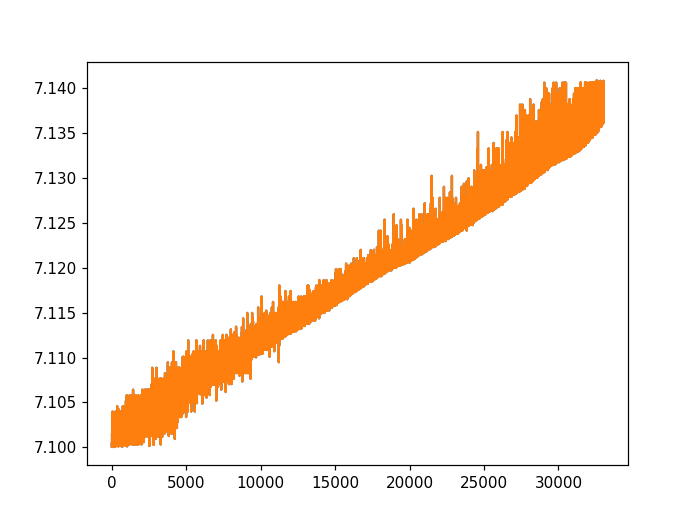

In [4]:
figure()
plot(first_moment(inp_axis, Xmono))
plot(first_moment(inp_axis, Xmono_s))

<IPython.core.display.Javascript object>


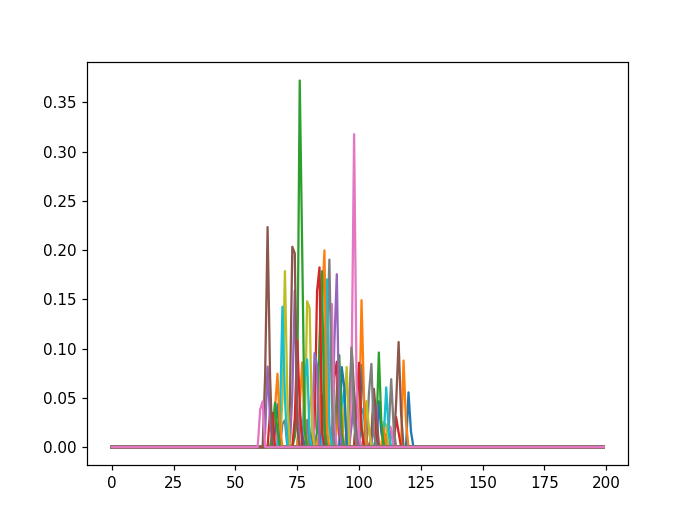

In [5]:
figure()
plot(Xmono[5::500,:].T);

In [6]:
def loggp_corrupt_sase(X, lenscale=0.1, amp_scale=0.1, trim=None):
    logX = np.log(np.clip(X, a_min = 1e-6, a_max = None))
    kern = gpflow.kernels.RBF(lengthscales=lenscale, variance=1.0)
    K = kern(np.linspace(-1,1,X.shape[-1])[:,None], full_cov=True) + 1e-6*np.eye(X.shape[-1])
    L = np.linalg.cholesky(K)
    L *= np.sqrt(amp_scale)
    corruption = (L @ np.random.normal(size=logX.shape).T).T
    if trim is not None:
        corruption[:,trim] *= 0.
    return np.exp(logX + corruption)

In [7]:
def poisson_corrupt_sase(X, alpha=500/3, maxnorm=True):
    Z = np.random.poisson(np.clip(X*alpha, a_min=1e-6, a_max=None)).astype('float64')
    if maxnorm:
        return Z/Z.max()
    else:
        return Z

In [84]:
pred_axis = np.linspace(inp_axis.max(),inp_axis.min(),1000)[:,None] #upsample by factor of 5
normalized_axis = np.linspace(-1,1,1000)[:,None]
sample_sizes = [42000]
alphas = [np.round(float(9000/9),2), np.round(float(9000/3),2),
          np.round(float(9000),2), np.round(3*float(9000),2)]
gammas = list(np.linspace(0,0.5,5))
for k, gamma in enumerate(gammas):
# for k, alpha in enumerate(alphas):
#     print(f'alpha is: {alpha}')
    print(f'gamma is: {gamma}')
    Ms_s = []
    Vs_s = []
    reports = []
    chunk_Ms_s = []
    vs = []
    ms = []
    chunk_m1s = []
    Y = Ymono_s[:,13][:,None]
    chunk_m1s.append(first_moment(inp_axis, Xmono_s).mean())
#     X = poisson_corrupt_sase(Xmono_s, alpha=alpha, maxnorm=False)
#     print(f'mean photons in X: {X.sum(-1).mean()}')
#     X /= alpha
    X = loggp_corrupt_sase(Xmono_s[:,:], amp_scale=gamma, lenscale=0.5, trim=None)
#     chunk_m1s.append(first_moment(inp_axis, Xpink[sel,:]).mean())
#     X = Xpink_adj
    print(f'prepared data for fit {k}')
    data = (X, Y)
    model = GPMM1D_Exact(data, gpflow.kernels.RBF(lengthscales=0.073, variance=0.02),
           noise_variance=3E-4, mean_function=gpflow.mean_functions.Zero(), jitter=1e-6)
    loss_fn = model.training_loss
    loss_fn()
    opt = gpflow.optimizers.Scipy()
    reports.append(opt.minimize(loss_fn, model.trainable_variables, options=dict(maxiter=1000)))
    if not reports[-1]['success']:
        print('optimization problem encountered')
    else:
        print(f'finished fit {k}')
    m, v = model.predict_f(normalized_axis)
#     ms.append(m[0,:][:,None])
#     vs.append(v[0,:][:,None])
    ms.append(m[:,None])
    vs.append(v[:,None])
    Ms_s.append(np.concatenate(ms,-1))
    Vs_s.append(np.concatenate(vs,-1))
    chunk_Ms_s.append(np.array(chunk_m1s))

    for k, cm in enumerate(chunk_Ms_s):
        si = np.argsort(cm)
        chunk_Ms_s[k] = cm[si]
        Ms_s[k] = Ms_s[k][:,si]
        Vs_s[k] = Vs_s[k][:,si]
        
    np.save(f'threshed_mono_multiplicative_corrupted_chunk_moments_ls0.1_gamma_is_{np.round(gamma,2)}.npy', chunk_Ms_s)
    np.save(f'threshed_mono_multiplicative_corrupted_chunk_means_ls0.1_gamma_is_{np.round(gamma,2)}.npy', Ms_s)
    np.save(f'threshed_mono_multiplicative_corrupted_chunk_vars_ls0.1_gamma_is_{np.round(gamma,2)}.npy', Vs_s)

#     np.save(f'mono_poisson_corrupted_chunk_moments_ls0.3_gamma_is_{np.round(alpha,2)}.npy', chunk_Ms_s)
#     np.save(f'mono_poisson_corrupted_chunk_means_ls0.3_gamma_is_{np.round(alpha,2)}.npy', Ms_s)
#     np.save(f'mono_poisson_corrupted_chunk_vars_ls0.3_gamma_is_{np.round(alpha,2)}.npy', Vs_s)
    
#     np.save(f'poisson_corrupted_chunk_moments_alpha_is_{np.round(alpha,2)}.npy', chunk_Ms_s)
#     np.save(f'poisson_corrupted_chunk_means_alpha_is_{np.round(alpha,2)}.npy', Ms_s)
#     np.save(f'poisson_corrupted_chunk_vars_alpha_is_{np.round(alpha,2)}.npy', Vs_s)

#     np.save(f'uncorrupted_chunk_moments.npy', chunk_Ms_s)
#     np.save(f'uncorrupted_chunk_means.npy', Ms_s)
#     np.save(f'uncorrupted_chunk_vars.npy', Vs_s)

#     np.save(f'real_chunk_moments.npy', chunk_Ms_s)
#     np.save(f'real_chunk_means.npy', Ms_s)
#     np.save(f'real_chunk_vars.npy', Vs_s)



gamma is: 0.0
prepared data for fit 0
finished fit 0
gamma is: 0.125
prepared data for fit 1
finished fit 1
gamma is: 0.25
prepared data for fit 2
finished fit 2
gamma is: 0.375
prepared data for fit 3
finished fit 3
gamma is: 0.5
prepared data for fit 4
finished fit 4


In [49]:
model

name,class,transform,prior,trainable,shape,dtype,value
GPMM1D_Exact.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.000309603
GPMM1D_Exact.kernel.variance,Parameter,Softplus,,True,(),float64,0.0194708
GPMM1D_Exact.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.073149
GPMM1D_Exact._pred_jitter_kernel.variance,Parameter,Softplus,,False,(),float64,1e-06


In [54]:
t0 = Xmono_s[:3000,:]
t = loggp_corrupt_sase(Xmono_s[:100,:], amp_scale=0.5, lenscale=0.1, trim=None)
# t = poisson_corrupt_sase(Xmono_s[:3000,:], alpha=9000, maxnorm=False)/9000

<IPython.core.display.Javascript object>


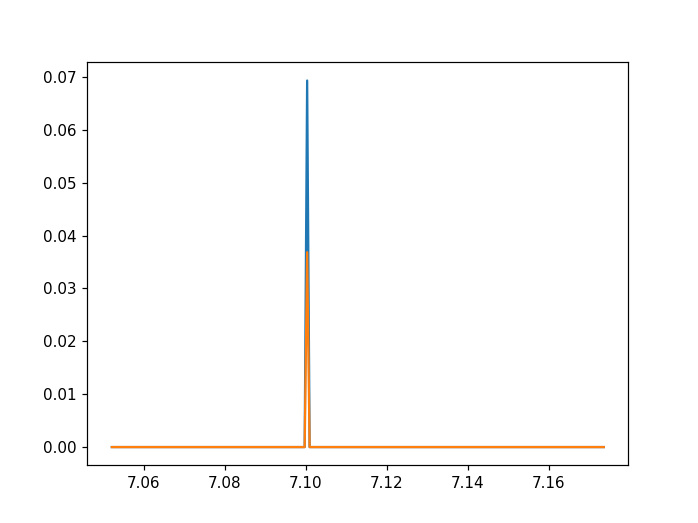

In [57]:
figure()
plot(inp_axis, t[57])
plot(inp_axis, t0[57])

<IPython.core.display.Javascript object>


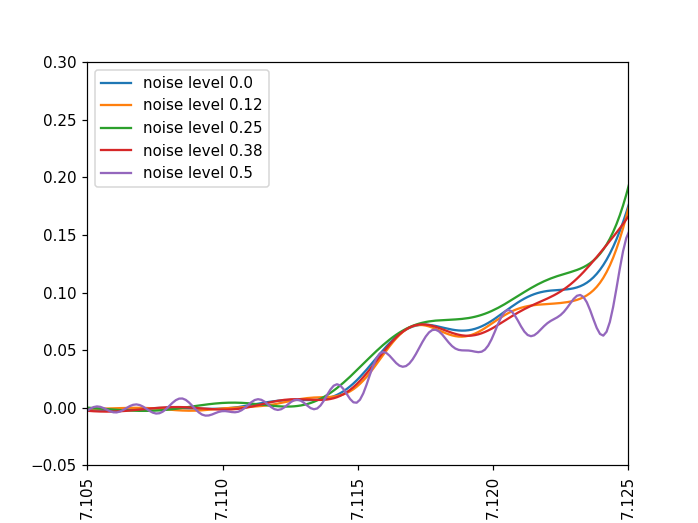

In [85]:
numps = [330]
# numps = [0.1]
fig = figure()
ax = fig.add_subplot(111)
# gammas = [0.0, 0.03, 0.1, 0.3, 0.5]
for gamma in gammas:
# for alpha in alphas:
    M = np.load(f'threshed_mono_multiplicative_corrupted_chunk_means_ls0.1_gamma_is_{np.round(gamma,2)}.npy')[0]
#     M = np.load(f'mono_poisson_corrupted_chunk_means_ls0.3_gamma_is_{alpha}.npy')[0]
    ax.plot(pred_axis, M[:,0]/M[355,0], label=f'noise level {np.round(gamma,2)}')
#     ax.plot(pred_axis, M[:,0]/M[355,0], label=f'noise level {alpha}')
xlim([7.105,7.125])
ylim([-0.05,0.3])
xticks([7.105,7.110,7.115,7.120,7.125,],rotation='vertical')
legend(loc=2)
    
savefig(f'./pre_edge_fake_mono_data_multiplicative_noise.pdf')
savefig(f'./pre_edge_fake_mono_data_multiplicative_noise.png')

# savefig(f'./pre_edge_fake_mono_data_poisson_noise.pdf')
# savefig(f'./pre_edge_fake_mono_data_poisson_noise.png')

<IPython.core.display.Javascript object>


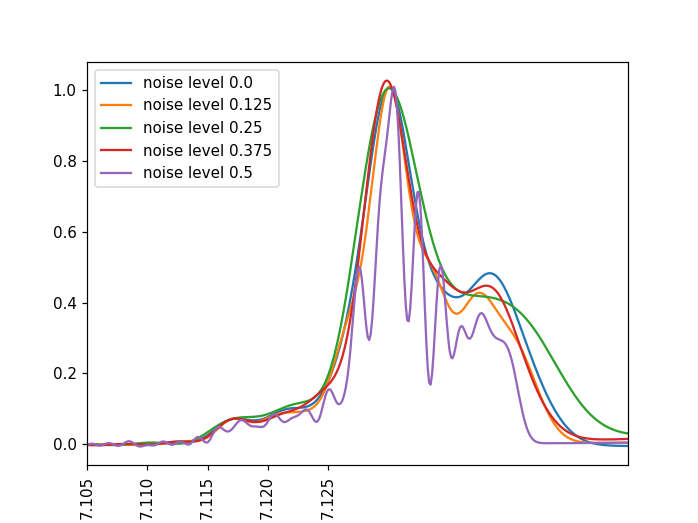

In [86]:
numps = [330]
# numps = [0.1]
fig = figure()
ax = fig.add_subplot(111)
for gamma in gammas:
# for alpha in alphas:
    M = np.load(f'threshed_mono_multiplicative_corrupted_chunk_means_ls0.1_gamma_is_{np.round(gamma,2)}.npy')[0]
#     M = np.load(f'mono_poisson_corrupted_chunk_means_ls0.3_gamma_is_{alpha}.npy')[0]
    ax.plot(pred_axis, M[:,0]/M[355,0], label=f'noise level {gamma}')
#     ax.plot(pred_axis, M[:,0]/M[355,0], label=f'noise level {alpha}')

xlim([7.105,7.150])
# ylim([-0.05,1.3])
xticks([7.105,7.110,7.115,7.120,7.125,],rotation='vertical')
legend(loc=2)
#     savefig(f'./pre_edge_subsets_of_fake_data_poisson_{nump}_photons.pdf')
#     savefig(f'./pre_edge_subsets_of_fake_data_poisson_{nump}_photons.png')

#     savefig(f'./pre_edge_subsets_of_fake_data_uncorrupted.pdf')
#     savefig(f'./pre_edge_subsets_of_fake_data_uncorrupted.png')

#     savefig(f'./pre_edge_subsets_of_real_data.pdf')
#     savefig(f'./pre_edge_subsets_of_real_data.png')

    
savefig(f'./whole_edge_fake_mono_data_multiplicative_noise.pdf')
savefig(f'./whole_edge_fake_mono_data_multiplicative_noise.png')

# savefig(f'./whole_edge_fake_mono_data_poisson_noise.pdf')
# savefig(f'./whole_edge_fake_mono_data_poisson_noise.png')

In [76]:
pred_axis = np.linspace(inp_axis.max(),inp_axis.min(),1000)[:,None] #upsample by factor of 5
normalized_axis = np.linspace(-1,1,1000)[:,None]
Ms = []
Vs = []
reports = []
chunk_Ms = []
sample_sizes = [10000]
for sample_size in sample_sizes:
    vs = []
    ms = []
    chunk_m1s = []
    slices = [slice(k,(k+1)*sample_size) for k in range(Xpink_adj.shape[0]//sample_size)]
    k = 0
    for sel in slices:
#         Y = Ypink_s[sel,13][:,None]
        Y = Ypink[sel,5:23]
        chunk_m1s.append(first_moment(inp_axis, Xpink_adj[sel,:]).mean())
        X = Xpink_adj[sel,:]
        print(f'prepared data for fit {k}')
        data = (X, Y)
#         model = GPMM1D_Exact(data, gpflow.kernels.Matern52(lengthscales=0.1, variance=0.01),
#            noise_variance=0.001, mean_function=gpflow.mean_functions.Constant(0.0), jitter=1e-8)
        model = GPMM2D_Exact(data, 
                    gpflow.kernels.Matern52(lengthscales=0.1, variance=0.01),
                    gpflow.kernels.RBF(lengthscales=0.1, variance=1.0),
                   noise_variance=data[1].var(),
                    mean_function=gpflow.mean_functions.Zero(), jitter=1e-8)
        #trigger compilation of loss
        loss_fn = model.training_loss
        loss_fn()
        opt = gpflow.optimizers.Scipy()
        reports.append(opt.minimize(loss_fn, model.trainable_variables, options=dict(maxiter=1000)))
        if not reports[-1]['success']:
            print('optimization problem encountered')
        else:
            print(f'finished fit {k}')
        m, v = model.predict_f(normalized_axis)
        ms.append(m[9,:][:,None])
        vs.append(v[9,:][:,None])
        k += 1
    Ms.append(np.concatenate(ms,-1))
    Vs.append(np.concatenate(vs,-1))
    chunk_Ms.append(np.array(chunk_m1s))

for k, cm in enumerate(chunk_Ms):
    si = np.argsort(cm)
    chunk_Ms[k] = cm[si]
    Ms[k] = Ms[k][:,si]
    Vs[k] = Vs[k][:,si]

prepared data for fit 0
finished fit 0
prepared data for fit 1
finished fit 1
prepared data for fit 2
finished fit 2
prepared data for fit 3
finished fit 3
prepared data for fit 4
finished fit 4
prepared data for fit 5
finished fit 5
prepared data for fit 6
finished fit 6
prepared data for fit 7
finished fit 7
prepared data for fit 8
finished fit 8
prepared data for fit 9
finished fit 9
prepared data for fit 10
finished fit 10
prepared data for fit 11
finished fit 11
prepared data for fit 12
finished fit 12
prepared data for fit 13
finished fit 13
prepared data for fit 14
finished fit 14
prepared data for fit 15
finished fit 15
prepared data for fit 16
finished fit 16
prepared data for fit 17
finished fit 17
prepared data for fit 18
finished fit 18


<IPython.core.display.Javascript object>


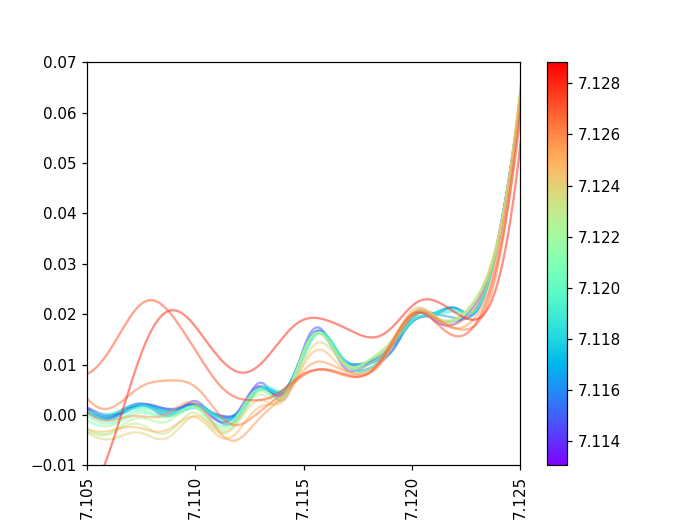

In [77]:
for M, cs, m1s in zip(Ms, sample_sizes, chunk_Ms):
    cm = get_cmap('rainbow')
    fig = figure()
    ax = fig.add_subplot(111)
    ax.set_prop_cycle(color=[cm(1.*i/M.shape[1]) for i in range(M.shape[1])])
    ax.plot(pred_axis, M, alpha=min(1,10/M.shape[1]))
#     ax.plot(pred_axis, 0.137*ferro_spline(pred_axis+1e-3),'k--',label='synchrotron reference')
    xlim([7.105,7.125])
    ylim([-0.01,0.07])
#     title(f'mean for 1st moment sorted {cs} shot subsets')
    fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=m1s.min(), vmax=m1s.max(), clip=False),
                            cmap=get_cmap('rainbow')), ax=ax)
    xticks([7.105,7.110,7.115,7.120,7.125,],rotation='vertical')
#     legend(loc=2)
    savefig(f'./pre_edge_{cs}_subsets_of_real_data.pdf')
    savefig(f'./pre_edge_{cs}_subsets_of_real_data.png') 

<IPython.core.display.Javascript object>


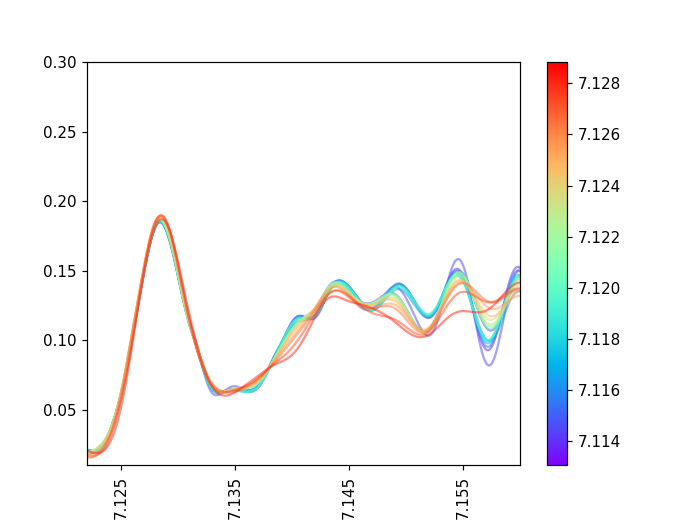

In [78]:
for M, cs, m1s in zip(Ms, sample_sizes, chunk_Ms):
    cm = get_cmap('rainbow')
    fig = figure()
    ax = fig.add_subplot(111)
    ax.set_prop_cycle(color=[cm(1.*i/M.shape[1]) for i in range(M.shape[1])])
    ax.plot(pred_axis, M, alpha=10/M.shape[1])
#     ax.plot(pred_axis, 0.137*ferro_spline(pred_axis+1e-3),'k--',label='synchrotron reference')
    xlim([7.122,7.160])
    ylim([0.01,0.3])
#     title(f'mean for 1st moment sorted {cs} shot subsets')
    fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=m1s.min(), vmax=m1s.max(), clip=False),
                            cmap=get_cmap('rainbow')), ax=ax)
    xticks([7.125,7.135,7.145,7.155],rotation='vertical')
#     legend(loc=2)
    savefig(f'./white_line_{cs}_subsets_of_real_data.pdf')
    savefig(f'./white_line_{cs}_subsets_of_real_data.png')   

In [5]:
def equal_time_strategy(M, Q):
    """
    equal time strategy refers to the measurement strategy of spending equal dwell time for a given
    monochromator setting.
    """
    Mask = np.ones((M, Q))
    onehot = np.eye(Q)

    chunksize = M / Q
    edges = [math.ceil(n * chunksize) for n in range(Q + 1)]
    for i in range(len(edges) - 1):
        s = slice(edges[i], edges[i + 1])
        Mask[s] *= onehot[i]
    return Mask

class FakeDataset(object):
    def __init__(self,
        spectrum_fun: Callable[[np.ndarray],np.ndarray] = ferro_spline,
        latent_axis: np.ndarray = np.linspace(7.100, 7.160, 100),
        nshots: int = 100000,
        sparsity: float = 1.0,
        bandwidth: float = 1.0,
        random_seed: Optional[int] = None,
        center: Optional[float] = 0.0,
        sigma2: Optional[float] = 1.,
    ):
        assert len(latent_axis.shape) == 1, "latent spectrum must be 1d"
        na = NormalizeAxis(latent_axis)
        R = latent_axis.shape[0]
        M = int(nshots)
        # set random seeds
        if random_seed is not None:
            self.seed = random_seed
            np.random.seed(self.seed)
        else:
            self.seed = 6969
            np.random.seed(self.seed)
    

        self.sase = make_sase(R, sparsity, nshots=M, 
                              bandwidth=na.scale(bandwidth),
                              center=na(center), normalize='max')
        self.na = na
        self._coherence = None
        self.latent_spectrum = np.clip(spectrum_fun(latent_axis), a_min=0., a_max=None)
        self.sigma2 = sigma2
        
    @property
    def coherence(self):
        if self._coherence is None:
            self._coherence = dask_delayed_coherence(self.sase)
        return self._coherence
        
    def __call__(self, snr, reps=3):
        noise_models = ['poisson', 'gaussian', 'poisson gaussian']
        latent_intensities = self.sase @ self.latent_spectrum[:,None]
        Npink = latent_intensities.mean()  # mean intensity response
        M, R = self.sase.shape

        data = {}
        data['pink'] = {
            'weights': self.sase, 
            'latent_targets': latent_intensities / Npink,
            'targets': np.zeros((M,3*reps)),
            'scaled_latent_targets': np.zeros((M,3*reps)),
            'latent_spectrum': np.zeros((self.latent_spectrum.shape[0],3*reps))
        }

        mask = equal_time_strategy(M, R)
        data['mono'] = {
            'weights': mask * self.sase,
            'latent_targets': ((mask * self.sase) @ self.latent_spectrum[:,None]) / Npink,
            'targets': np.zeros((M,3*reps)),
            'scaled_latent_targets': np.zeros((M,3*reps)),
            'latent_spectrum': np.zeros((R,3*reps))
        }

        for noise_model in noise_models:
            if noise_model == "poisson":
                for name, d in data.items():
                    for rep in range(reps):
                        np.random.seed(self.seed+rep*100)
                        # we set latent signal scaling using pink
                        # latent targets.
                        sel = 0 + rep*3
                        mu_pink = (latent_intensities / Npink).mean()
                        var_pink = (latent_intensities / Npink).var()
                        k = snr*mu_pink/(var_pink + mu_pink**2*(1 - snr))
                        d['targets'][:,sel] = np.squeeze(np.random.poisson(lam=d['latent_targets']*k))
                        d['scaled_latent_targets'][:,sel] = np.squeeze(d['latent_targets']*k)
                        d['latent_spectrum'][:,sel] = self.latent_spectrum*k/Npink
                        d['p_scaling_factor'] = k
            elif noise_model == "gaussian":
                for name, d in data.items():
                    for rep in range(reps):
                        np.random.seed(self.seed+rep*133)
                        sel = 1 + rep*3
                        mu_pink = (latent_intensities / Npink).mean()
                        var_pink = (latent_intensities / Npink).var()
                        k = np.sqrt(snr/((1-snr)*(mu_pink**2 + var_pink)))
                        d['targets'][:,sel] = np.squeeze(d['latent_targets']*k + np.random.normal(size=d['latent_targets'].shape))
                        d['scaled_latent_targets'][:,sel] = np.squeeze(d['latent_targets']*k)
                        d['latent_spectrum'][:,sel] = self.latent_spectrum*k / Npink
                        d['g_scaling_factor'] = k
            elif noise_model == "poisson gaussian":
                for name, d in data.items():
                    for rep in range(reps):
                        np.random.seed(self.seed+rep*133)
                        sel = 2 + rep*3
                        mu_pink = (latent_intensities / Npink).mean()
                        var_pink = (latent_intensities / Npink).var()
                        k = (snr*mu_pink + np.sqrt(snr*(snr*mu_pink**2 + 4*self.sigma2*(mu_pink**2+var_pink-snr*mu_pink**2))))
                        k /= 2*(var_pink-(snr-1)*mu_pink**2)
                        d['targets'][:,sel] = np.squeeze(np.random.poisson(lam=d['latent_targets']*k) + \
                                        np.random.normal(scale=math.sqrt(self.sigma2), size=d['latent_targets'].shape))
                        d['scaled_latent_targets'][:,sel] = np.squeeze(d['latent_targets']*k)
                        d['latent_spectrum'][:,sel] = self.latent_spectrum*k/Npink
                        d['pg_scaling_factor'] = k
            else:
                raise NotImplemented("unknown noise model")
        return data

    
def verify_snr(latent_targets, targets):
    return (latent_targets.mean()**2 + latent_targets.var()) / (targets.var() + targets.mean()**2)

In [6]:
def relative_norm(x,ref):
    if len(x.shape)==1:
        return np.linalg.norm(x/ref.max())/len(x)
    else:
        return np.array([np.linalg.norm(x[:,j]/ref[:,j].max())/len(x[:,j]) for j in range(x.shape[1])])

In [7]:
dataset_parameters = {
    'spectrum_fun': ferro_spline,
    'latent_axis': np.linspace(7.110, 7.170, 100),
    'nshots': 100000,
    'sparsity': 3.0,
    'bandwidth': 0.03,
    'random_seed': 5123,
    'center': 7.115,
    'sigma2': 0.125**2,
}

# DG = FakeDataset(**dataset_parameters)
def sweep_snr_nsase_photons(dataset, snrs=np.linspace(0.1,0.85,30), 
                            reps: int = 30, nphoton_min = 2, nphoton_max = 5):
    Results = {
               'snrs': [],
               'poisson': {'pink': [], 'mono': []},
               'gaussian': {'pink': [], 'mono': []},
               'poisson gaussian': {'pink': [], 'mono': []},
               'coherence': None#dataset.coherence,
              }
    sase_nphotons = np.logspace(nphoton_min, nphoton_max, reps//9)
    for c,snr in enumerate(snrs):
        Results['snrs'].append(snr)
        data = dataset(snr, reps = reps)
        Wsase = data['pink']['weights']
        Wsase_mean = Wsase.mean()
        for kind in ['pink', 'mono']:
            for noise_model in ['poisson', 'gaussian', 'poisson gaussian']:
                if noise_model == 'poisson':
                    sel = 0
                elif noise_model == 'gaussian':
                    sel = 1
                elif noise_model == 'poisson gaussian':
                    sel = 2
                else:
                    raise ValueError(f'unexpected noise model, got {noise_model}')
                j = sel
                k = 0
                npi = 0
                for rep in range(reps):
                    print(f'rep: {rep}')
                    if k == 9:
                        k = 0
                        npi += 1
                    k += 1
                    W = data[kind]['weights']
                    # this draws photons so that for SASE, we get on average sase_nphotons
                    # but for mono version, the scaling is preserved (so same photons/pixel)
                    Wc = np.random.poisson(lam=sase_nphotons[npi]*W/Wsase_mean)
                    Wcn = Wc/Wc.max()
                    dd = (tf.convert_to_tensor(Wcn, dtype=tf.float64),
                          tf.convert_to_tensor(data[kind]['targets'][:,j][:,None], dtype=tf.float64))
                    clipped_latent_std = np.clip(data[kind]['latent_spectrum'][:,j].std(),
                                                 a_min=1e-3, a_max=100)
                    noise_est = np.clip((np.squeeze(data[kind]['scaled_latent_targets'][:,j]) - 
                                         np.squeeze(data[kind]['targets'][:,j])).std(),
                                        a_min = 1e-3, a_max = None)
                    latent_mean = data[kind]['latent_spectrum'][:,j].mean()
#                     print(c,kind,noise_model,rep,clipped_latent_std,latent_mean,noise_est,j)
                    model = GPMM1D_Exact(dd, 
                                     gpflow.kernels.Matern52(lengthscales=0.1,variance=clipped_latent_std),
                                     gpflow.mean_functions.Constant(latent_mean),
                                    noise_variance=noise_est/500,
                                    jitter=1e-7)
                    opt = gpflow.optimizers.Scipy()
                    loss = model.training_loss
                    loss()
                    report = opt.minimize(loss, model.trainable_variables, options=dict(maxiter=150))
                        
                    if not report['success']:
                        raise ValueError('Optimization did not converge')
                    m, v = model.predict_f(dataset.na(dataset_parameters['latent_axis'][:,None]))
                    if rep == 0:
                        Results[noise_model][kind].append({
                            'mean_soln': [np.squeeze(np.copy(m))],
                            'var_soln': [np.squeeze(np.copy(v))],
                            'latent_spectrum': [np.squeeze(np.copy(data[kind]['latent_spectrum'][:,j]))],
                            'real_snr': [verify_snr(data[kind]['scaled_latent_targets'][:,j], data[kind]['targets'][:,j])],
                            'mean_sase_photons': [Wc.mean()]
                        })
                    else:
                        Results[noise_model][kind][c]['mean_soln'].append(np.squeeze(np.copy(m)))
                        Results[noise_model][kind][c]['var_soln'].append(np.squeeze(np.copy(v))),
                        Results[noise_model][kind][c]['latent_spectrum'].append(np.squeeze(np.copy(data[kind]['latent_spectrum'][:,j]))),
                        Results[noise_model][kind][c]['real_snr'].append(verify_snr(data[kind]['scaled_latent_targets'][:,j], data[kind]['targets'][:,j]))
                        Results[noise_model][kind][c]['mean_sase_photons'].append(Wc.mean())
                    if rep == reps-1:
                        # now consolidate
                        Results[noise_model][kind][c]['mean_soln'] = np.stack(Results[noise_model][kind][c]['mean_soln'],-1)
                        Results[noise_model][kind][c]['var_soln'] = np.stack(Results[noise_model][kind][c]['var_soln'],-1)
                        Results[noise_model][kind][c]['latent_spectrum'] = np.stack(Results[noise_model][kind][c]['latent_spectrum'],-1)
                        Results[noise_model][kind][c]['real_snr'] = np.array(Results[noise_model][kind][c]['real_snr'])
                        Results[noise_model][kind][c]['mean_sase_photons'] = np.array(Results[noise_model][kind][c]['mean_sase_photons'])
                    j += 3
                        
    return Results

In [10]:
dname = 'clean_sorted_200mM_ferrocyanide_pink_all'
# dname = 'finely_corrected_and_biased_pink'
with h5py.File('/home/fdfuller/work/data/sacla2017/' + dname + '.h5','r') as fid:
    inp_axis = np.array(fid['inp_axis'])
    out_axis = np.array(fid['out_axis_binned'])
#     print(fid.keys())
#     Xpink = np.concatenate([np.array(fid['X_by_first_sase_moment_cluster_a']).astype('float64'), 
#                             np.array(fid['X_by_first_sase_moment_cluster_b']).astype('float64')],
#                            0)
    Xpinka = np.array(fid['X_by_first_sase_moment_cluster_a']).astype('float64')
    Xpinkb = np.array(fid['X_by_first_sase_moment_cluster_b']).astype('float64')
    Xpink = np.concatenate([Xpinka, Xpinkb],0)
    xmax = Xpink.max()
    Xpink /= xmax
    Xpinka /= xmax
    Xpinkb /= xmax
#     Xpink = np.clip(Xpink, a_min=0., a_max=None)
#     Xpinka = np.clip(Xpinka, a_min=0., a_max=None)
#     Xpinkb = np.clip(Xpinkb, a_min=0., a_max=None)
#     Ypink = np.concatenate([np.array(fid['Ybinned_by_first_sase_moment_cluster_a']).astype('float64'),
#                             np.array(fid['Ybinned_by_first_sase_moment_cluster_b']).astype('float64')],0)
    Ypinka = np.array(fid['Ybinned_by_first_sase_moment_cluster_a']).astype('float64')
    Ypinkb = np.array(fid['Ybinned_by_first_sase_moment_cluster_b']).astype('float64')
    Ypink = np.concatenate([Ypinka, Ypinkb],0)
    ymax = Ypink.max()
    Ypink /= ymax
    Ypinka /= ymax
    Ypinkb /= ymax


In [11]:
fig2shots = np.load('../data_analysis/fig2_selected_shots.npy',allow_pickle=True)[()]

In [12]:
Xfig2 = np.concatenate([Xpinka[fig2shots['shot_choicesa']], Xpinkb[fig2shots['shot_choicesb']]], 0)

In [13]:
dask_delayed_coherence(Xfig2)

2.25362406914874

In [33]:
dataset_parameters = {
    'spectrum_fun': ferro_spline,
    'latent_axis': np.linspace(7.110, 7.170, 100),
    'nshots': 10000,
    'sparsity': 3.6,
    'bandwidth': 0.03,
    'random_seed': 5123,
    'center': 7.115,
    'sigma2': 0.125**2,
}
DG = FakeDataset(**dataset_parameters)

In [34]:
DG.coherence

2.283855814943401

In [45]:
dataset_parameters = {
    'spectrum_fun': ferro_spline,
    'latent_axis': np.linspace(7.110, 7.170, 100),
    'nshots': 100000,
    'sparsity': 3.0,
    'bandwidth': 0.03,
    'random_seed': 5127,
    'center': 7.115,
    'sigma2': 0.125**2,
}
#note to self, skipped 8th coherence. Need to go back to that.

dataset_parameters['sparsity'] = 3.6
results = sweep_snr_nsase_photons(FakeDataset(**dataset_parameters), snrs=np.linspace(0.1,0.9,30), reps = 90)
fname = f"./sim_results/noise_sase_results_3.npy"
np.save(fname, results)

    

rep: 0
rep: 1
rep: 2
rep: 3
rep: 4
rep: 5
rep: 6
rep: 7
rep: 8
rep: 9
rep: 10
rep: 11
rep: 12
rep: 13
rep: 14
rep: 15
rep: 16
rep: 17
rep: 18
rep: 19
rep: 20
rep: 21
rep: 22
rep: 23
rep: 24
rep: 25
rep: 26
rep: 27
rep: 28
rep: 29
rep: 30
rep: 31
rep: 32
rep: 33
rep: 34
rep: 35
rep: 36
rep: 37
rep: 38
rep: 39
rep: 40
rep: 41
rep: 42
rep: 43
rep: 44
rep: 45
rep: 46
rep: 47
rep: 48
rep: 49
rep: 50
rep: 51
rep: 52
rep: 53
rep: 54
rep: 55
rep: 56
rep: 57
rep: 58
rep: 59
rep: 60
rep: 61
rep: 62
rep: 63
rep: 64
rep: 65
rep: 66
rep: 67
rep: 68
rep: 69
rep: 70
rep: 71
rep: 72
rep: 73
rep: 74
rep: 75
rep: 76
rep: 77
rep: 78
rep: 79
rep: 80
rep: 81
rep: 82
rep: 83
rep: 84
rep: 85
rep: 86
rep: 87
rep: 88
rep: 89
rep: 0
rep: 1
rep: 2
rep: 3
rep: 4
rep: 5
rep: 6
rep: 7
rep: 8
rep: 9
rep: 10
rep: 11
rep: 12
rep: 13
rep: 14
rep: 15
rep: 16
rep: 17
rep: 18
rep: 19
rep: 20
rep: 21
rep: 22
rep: 23
rep: 24
rep: 25
rep: 26
rep: 27
rep: 28
rep: 29
rep: 30
rep: 31
rep: 32
rep: 33
rep: 34
rep: 35
rep: 36
rep:

rep: 50
rep: 51
rep: 52
rep: 53
rep: 54
rep: 55
rep: 56
rep: 57
rep: 58
rep: 59
rep: 60
rep: 61
rep: 62
rep: 63
rep: 64
rep: 65
rep: 66
rep: 67
rep: 68
rep: 69
rep: 70
rep: 71
rep: 72
rep: 73
rep: 74
rep: 75
rep: 76
rep: 77
rep: 78
rep: 79
rep: 80
rep: 81
rep: 82
rep: 83
rep: 84
rep: 85
rep: 86
rep: 87
rep: 88
rep: 89
rep: 0
rep: 1
rep: 2
rep: 3
rep: 4
rep: 5
rep: 6
rep: 7
rep: 8
rep: 9
rep: 10
rep: 11
rep: 12
rep: 13
rep: 14
rep: 15
rep: 16
rep: 17
rep: 18
rep: 19
rep: 20
rep: 21
rep: 22
rep: 23
rep: 24
rep: 25
rep: 26
rep: 27
rep: 28
rep: 29
rep: 30
rep: 31
rep: 32
rep: 33
rep: 34
rep: 35
rep: 36
rep: 37
rep: 38
rep: 39
rep: 40
rep: 41
rep: 42
rep: 43
rep: 44
rep: 45
rep: 46
rep: 47
rep: 48
rep: 49
rep: 50
rep: 51
rep: 52
rep: 53
rep: 54
rep: 55
rep: 56
rep: 57
rep: 58
rep: 59
rep: 60
rep: 61
rep: 62
rep: 63
rep: 64
rep: 65
rep: 66
rep: 67
rep: 68
rep: 69
rep: 70
rep: 71
rep: 72
rep: 73
rep: 74
rep: 75
rep: 76
rep: 77
rep: 78
rep: 79
rep: 80
rep: 81
rep: 82
rep: 83
rep: 84
rep: 85
re

rep: 9
rep: 10
rep: 11
rep: 12
rep: 13
rep: 14
rep: 15
rep: 16
rep: 17
rep: 18
rep: 19
rep: 20
rep: 21
rep: 22
rep: 23
rep: 24
rep: 25
rep: 26
rep: 27
rep: 28
rep: 29
rep: 30
rep: 31
rep: 32
rep: 33
rep: 34
rep: 35
rep: 36
rep: 37
rep: 38
rep: 39
rep: 40
rep: 41
rep: 42
rep: 43
rep: 44
rep: 45
rep: 46
rep: 47
rep: 48
rep: 49
rep: 50
rep: 51
rep: 52
rep: 53
rep: 54
rep: 55
rep: 56
rep: 57
rep: 58
rep: 59
rep: 60
rep: 61
rep: 62
rep: 63
rep: 64
rep: 65
rep: 66
rep: 67
rep: 68
rep: 69
rep: 70
rep: 71
rep: 72
rep: 73
rep: 74
rep: 75
rep: 76
rep: 77
rep: 78
rep: 79
rep: 80
rep: 81
rep: 82
rep: 83
rep: 84
rep: 85
rep: 86
rep: 87
rep: 88
rep: 89
rep: 0
rep: 1
rep: 2
rep: 3
rep: 4
rep: 5
rep: 6
rep: 7
rep: 8
rep: 9
rep: 10
rep: 11
rep: 12
rep: 13
rep: 14
rep: 15
rep: 16
rep: 17
rep: 18
rep: 19
rep: 20
rep: 21
rep: 22
rep: 23
rep: 24
rep: 25
rep: 26
rep: 27
rep: 28
rep: 29
rep: 30
rep: 31
rep: 32
rep: 33
rep: 34
rep: 35
rep: 36
rep: 37
rep: 38
rep: 39
rep: 40
rep: 41
rep: 42
rep: 43
rep: 44
rep

rep: 57
rep: 58
rep: 59
rep: 60
rep: 61
rep: 62
rep: 63
rep: 64
rep: 65
rep: 66
rep: 67
rep: 68
rep: 69
rep: 70
rep: 71
rep: 72
rep: 73
rep: 74
rep: 75
rep: 76
rep: 77
rep: 78
rep: 79
rep: 80
rep: 81
rep: 82
rep: 83
rep: 84
rep: 85
rep: 86
rep: 87
rep: 88
rep: 89
rep: 0
rep: 1
rep: 2
rep: 3
rep: 4
rep: 5
rep: 6
rep: 7
rep: 8
rep: 9
rep: 10
rep: 11
rep: 12
rep: 13
rep: 14
rep: 15
rep: 16
rep: 17
rep: 18
rep: 19
rep: 20
rep: 21
rep: 22
rep: 23
rep: 24
rep: 25
rep: 26
rep: 27
rep: 28
rep: 29
rep: 30
rep: 31
rep: 32
rep: 33
rep: 34
rep: 35
rep: 36
rep: 37
rep: 38
rep: 39
rep: 40
rep: 41
rep: 42
rep: 43
rep: 44
rep: 45
rep: 46
rep: 47
rep: 48
rep: 49
rep: 50
rep: 51
rep: 52
rep: 53
rep: 54
rep: 55
rep: 56
rep: 57
rep: 58
rep: 59
rep: 60
rep: 61
rep: 62
rep: 63
rep: 64
rep: 65
rep: 66
rep: 67
rep: 68
rep: 69
rep: 70
rep: 71
rep: 72
rep: 73
rep: 74
rep: 75
rep: 76
rep: 77
rep: 78
rep: 79
rep: 80
rep: 81
rep: 82
rep: 83
rep: 84
rep: 85
rep: 86
rep: 87
rep: 88
rep: 89
rep: 0
rep: 1
rep: 2
rep: 

rep: 17
rep: 18
rep: 19
rep: 20
rep: 21
rep: 22
rep: 23
rep: 24
rep: 25
rep: 26
rep: 27
rep: 28
rep: 29
rep: 30
rep: 31
rep: 32
rep: 33
rep: 34
rep: 35
rep: 36
rep: 37
rep: 38
rep: 39
rep: 40
rep: 41
rep: 42
rep: 43
rep: 44
rep: 45
rep: 46
rep: 47
rep: 48
rep: 49
rep: 50
rep: 51
rep: 52
rep: 53
rep: 54
rep: 55
rep: 56
rep: 57
rep: 58
rep: 59
rep: 60
rep: 61
rep: 62
rep: 63
rep: 64
rep: 65
rep: 66
rep: 67
rep: 68
rep: 69
rep: 70
rep: 71
rep: 72
rep: 73
rep: 74
rep: 75
rep: 76
rep: 77
rep: 78
rep: 79
rep: 80
rep: 81
rep: 82
rep: 83
rep: 84
rep: 85
rep: 86
rep: 87
rep: 88
rep: 89
rep: 0
rep: 1
rep: 2
rep: 3
rep: 4
rep: 5
rep: 6
rep: 7
rep: 8
rep: 9
rep: 10
rep: 11
rep: 12
rep: 13
rep: 14
rep: 15
rep: 16
rep: 17
rep: 18
rep: 19
rep: 20
rep: 21
rep: 22
rep: 23
rep: 24
rep: 25
rep: 26
rep: 27
rep: 28
rep: 29
rep: 30
rep: 31
rep: 32
rep: 33
rep: 34
rep: 35
rep: 36
rep: 37
rep: 38
rep: 39
rep: 40
rep: 41
rep: 42
rep: 43
rep: 44
rep: 45
rep: 46
rep: 47
rep: 48
rep: 49
rep: 50
rep: 51
rep: 52
re

rep: 65
rep: 66
rep: 67
rep: 68
rep: 69
rep: 70
rep: 71
rep: 72
rep: 73
rep: 74
rep: 75
rep: 76
rep: 77
rep: 78
rep: 79
rep: 80
rep: 81
rep: 82
rep: 83
rep: 84
rep: 85
rep: 86
rep: 87
rep: 88
rep: 89
rep: 0
rep: 1
rep: 2
rep: 3
rep: 4
rep: 5
rep: 6
rep: 7
rep: 8
rep: 9
rep: 10
rep: 11
rep: 12
rep: 13
rep: 14
rep: 15
rep: 16
rep: 17
rep: 18
rep: 19
rep: 20
rep: 21
rep: 22
rep: 23
rep: 24
rep: 25
rep: 26
rep: 27
rep: 28
rep: 29
rep: 30
rep: 31
rep: 32
rep: 33
rep: 34
rep: 35
rep: 36
rep: 37
rep: 38
rep: 39
rep: 40
rep: 41
rep: 42
rep: 43
rep: 44
rep: 45
rep: 46
rep: 47
rep: 48
rep: 49
rep: 50
rep: 51
rep: 52
rep: 53
rep: 54
rep: 55
rep: 56
rep: 57
rep: 58
rep: 59
rep: 60
rep: 61
rep: 62
rep: 63
rep: 64
rep: 65
rep: 66
rep: 67
rep: 68
rep: 69
rep: 70
rep: 71
rep: 72
rep: 73
rep: 74
rep: 75
rep: 76
rep: 77
rep: 78
rep: 79
rep: 80
rep: 81
rep: 82
rep: 83
rep: 84
rep: 85
rep: 86
rep: 87
rep: 88
rep: 89
rep: 0
rep: 1
rep: 2
rep: 3
rep: 4
rep: 5
rep: 6
rep: 7
rep: 8
rep: 9
rep: 10
rep: 11
rep:

rep: 25
rep: 26
rep: 27
rep: 28
rep: 29
rep: 30
rep: 31
rep: 32
rep: 33
rep: 34
rep: 35
rep: 36
rep: 37
rep: 38
rep: 39
rep: 40
rep: 41
rep: 42
rep: 43
rep: 44
rep: 45
rep: 46
rep: 47
rep: 48
rep: 49
rep: 50
rep: 51
rep: 52
rep: 53
rep: 54
rep: 55
rep: 56
rep: 57
rep: 58
rep: 59
rep: 60
rep: 61
rep: 62
rep: 63
rep: 64
rep: 65
rep: 66
rep: 67
rep: 68
rep: 69
rep: 70
rep: 71
rep: 72
rep: 73
rep: 74
rep: 75
rep: 76
rep: 77
rep: 78
rep: 79
rep: 80
rep: 81
rep: 82
rep: 83
rep: 84
rep: 85
rep: 86
rep: 87
rep: 88
rep: 89
rep: 0
rep: 1
rep: 2
rep: 3
rep: 4
rep: 5
rep: 6
rep: 7
rep: 8
rep: 9
rep: 10
rep: 11
rep: 12
rep: 13
rep: 14
rep: 15
rep: 16
rep: 17
rep: 18
rep: 19
rep: 20
rep: 21
rep: 22
rep: 23
rep: 24
rep: 25
rep: 26
rep: 27
rep: 28
rep: 29
rep: 30
rep: 31
rep: 32
rep: 33
rep: 34
rep: 35
rep: 36
rep: 37
rep: 38
rep: 39
rep: 40
rep: 41
rep: 42
rep: 43
rep: 44
rep: 45
rep: 46
rep: 47
rep: 48
rep: 49
rep: 50
rep: 51
rep: 52
rep: 53
rep: 54
rep: 55
rep: 56
rep: 57
rep: 58
rep: 59
rep: 60
re

rep: 73
rep: 74
rep: 75
rep: 76
rep: 77
rep: 78
rep: 79
rep: 80
rep: 81
rep: 82
rep: 83
rep: 84
rep: 85
rep: 86
rep: 87
rep: 88
rep: 89
rep: 0
rep: 1
rep: 2
rep: 3
rep: 4
rep: 5
rep: 6
rep: 7
rep: 8
rep: 9
rep: 10
rep: 11
rep: 12
rep: 13
rep: 14
rep: 15
rep: 16
rep: 17
rep: 18
rep: 19
rep: 20
rep: 21
rep: 22
rep: 23
rep: 24
rep: 25
rep: 26
rep: 27
rep: 28
rep: 29
rep: 30
rep: 31
rep: 32
rep: 33
rep: 34
rep: 35
rep: 36
rep: 37
rep: 38
rep: 39
rep: 40
rep: 41
rep: 42
rep: 43
rep: 44
rep: 45
rep: 46
rep: 47
rep: 48
rep: 49
rep: 50
rep: 51
rep: 52
rep: 53
rep: 54
rep: 55
rep: 56
rep: 57
rep: 58
rep: 59
rep: 60
rep: 61
rep: 62
rep: 63
rep: 64
rep: 65
rep: 66
rep: 67
rep: 68
rep: 69
rep: 70
rep: 71
rep: 72
rep: 73
rep: 74
rep: 75
rep: 76
rep: 77
rep: 78
rep: 79
rep: 80
rep: 81
rep: 82
rep: 83
rep: 84
rep: 85
rep: 86
rep: 87
rep: 88
rep: 89
rep: 0
rep: 1
rep: 2
rep: 3
rep: 4
rep: 5
rep: 6
rep: 7
rep: 8
rep: 9
rep: 10
rep: 11
rep: 12
rep: 13
rep: 14
rep: 15
rep: 16
rep: 17
rep: 18
rep: 19
rep:

rep: 33
rep: 34
rep: 35
rep: 36
rep: 37
rep: 38
rep: 39
rep: 40
rep: 41
rep: 42
rep: 43
rep: 44
rep: 45
rep: 46
rep: 47
rep: 48
rep: 49
rep: 50
rep: 51
rep: 52
rep: 53
rep: 54
rep: 55
rep: 56
rep: 57
rep: 58
rep: 59
rep: 60
rep: 61
rep: 62
rep: 63
rep: 64
rep: 65
rep: 66
rep: 67
rep: 68
rep: 69
rep: 70
rep: 71
rep: 72
rep: 73
rep: 74
rep: 75
rep: 76
rep: 77
rep: 78
rep: 79
rep: 80
rep: 81
rep: 82
rep: 83
rep: 84
rep: 85
rep: 86
rep: 87
rep: 88
rep: 89
rep: 0
rep: 1
rep: 2
rep: 3
rep: 4
rep: 5
rep: 6
rep: 7
rep: 8
rep: 9
rep: 10
rep: 11
rep: 12
rep: 13
rep: 14
rep: 15
rep: 16
rep: 17
rep: 18
rep: 19
rep: 20
rep: 21
rep: 22
rep: 23
rep: 24
rep: 25
rep: 26
rep: 27
rep: 28
rep: 29
rep: 30
rep: 31
rep: 32
rep: 33
rep: 34
rep: 35
rep: 36
rep: 37
rep: 38
rep: 39
rep: 40
rep: 41
rep: 42
rep: 43
rep: 44
rep: 45
rep: 46
rep: 47
rep: 48
rep: 49
rep: 50
rep: 51
rep: 52
rep: 53
rep: 54
rep: 55
rep: 56
rep: 57
rep: 58
rep: 59
rep: 60
rep: 61
rep: 62
rep: 63
rep: 64
rep: 65
rep: 66
rep: 67
rep: 68
re

rep: 81
rep: 82
rep: 83
rep: 84
rep: 85
rep: 86
rep: 87
rep: 88
rep: 89
rep: 0
rep: 1
rep: 2
rep: 3
rep: 4
rep: 5
rep: 6
rep: 7
rep: 8
rep: 9
rep: 10
rep: 11
rep: 12
rep: 13
rep: 14
rep: 15
rep: 16
rep: 17
rep: 18
rep: 19
rep: 20
rep: 21
rep: 22
rep: 23
rep: 24
rep: 25
rep: 26
rep: 27
rep: 28
rep: 29
rep: 30
rep: 31
rep: 32
rep: 33
rep: 34
rep: 35
rep: 36
rep: 37
rep: 38
rep: 39
rep: 40
rep: 41
rep: 42
rep: 43
rep: 44
rep: 45
rep: 46
rep: 47
rep: 48
rep: 49
rep: 50
rep: 51
rep: 52
rep: 53
rep: 54
rep: 55
rep: 56
rep: 57
rep: 58
rep: 59
rep: 60
rep: 61
rep: 62
rep: 63
rep: 64
rep: 65
rep: 66
rep: 67
rep: 68
rep: 69
rep: 70
rep: 71
rep: 72
rep: 73
rep: 74
rep: 75
rep: 76
rep: 77
rep: 78
rep: 79
rep: 80
rep: 81
rep: 82
rep: 83
rep: 84
rep: 85
rep: 86
rep: 87
rep: 88
rep: 89
rep: 0
rep: 1
rep: 2
rep: 3
rep: 4
rep: 5
rep: 6
rep: 7
rep: 8
rep: 9
rep: 10
rep: 11
rep: 12
rep: 13
rep: 14
rep: 15
rep: 16
rep: 17
rep: 18
rep: 19
rep: 20
rep: 21
rep: 22
rep: 23
rep: 24
rep: 25
rep: 26
rep: 27
rep:

rep: 41
rep: 42
rep: 43
rep: 44
rep: 45
rep: 46
rep: 47
rep: 48
rep: 49
rep: 50
rep: 51
rep: 52
rep: 53
rep: 54
rep: 55
rep: 56
rep: 57
rep: 58
rep: 59
rep: 60
rep: 61
rep: 62
rep: 63
rep: 64
rep: 65
rep: 66
rep: 67
rep: 68
rep: 69
rep: 70
rep: 71
rep: 72
rep: 73
rep: 74
rep: 75
rep: 76
rep: 77
rep: 78
rep: 79
rep: 80
rep: 81
rep: 82
rep: 83
rep: 84
rep: 85
rep: 86
rep: 87
rep: 88
rep: 89
rep: 0
rep: 1
rep: 2
rep: 3
rep: 4
rep: 5
rep: 6
rep: 7
rep: 8
rep: 9
rep: 10
rep: 11
rep: 12
rep: 13
rep: 14
rep: 15
rep: 16
rep: 17
rep: 18
rep: 19
rep: 20
rep: 21
rep: 22
rep: 23
rep: 24
rep: 25
rep: 26
rep: 27
rep: 28
rep: 29
rep: 30
rep: 31
rep: 32
rep: 33
rep: 34
rep: 35
rep: 36
rep: 37
rep: 38
rep: 39
rep: 40
rep: 41
rep: 42
rep: 43
rep: 44
rep: 45
rep: 46
rep: 47
rep: 48
rep: 49
rep: 50
rep: 51
rep: 52
rep: 53
rep: 54
rep: 55
rep: 56
rep: 57
rep: 58
rep: 59
rep: 60
rep: 61
rep: 62
rep: 63
rep: 64
rep: 65
rep: 66
rep: 67
rep: 68
rep: 69
rep: 70
rep: 71
rep: 72
rep: 73
rep: 74
rep: 75
rep: 76
re

rep: 89
rep: 0
rep: 1
rep: 2
rep: 3
rep: 4
rep: 5
rep: 6
rep: 7
rep: 8
rep: 9
rep: 10
rep: 11
rep: 12
rep: 13
rep: 14
rep: 15
rep: 16
rep: 17
rep: 18
rep: 19
rep: 20
rep: 21
rep: 22
rep: 23
rep: 24
rep: 25
rep: 26
rep: 27
rep: 28
rep: 29
rep: 30
rep: 31
rep: 32
rep: 33
rep: 34
rep: 35
rep: 36
rep: 37
rep: 38
rep: 39
rep: 40
rep: 41
rep: 42
rep: 43
rep: 44
rep: 45
rep: 46
rep: 47
rep: 48
rep: 49
rep: 50
rep: 51
rep: 52
rep: 53
rep: 54
rep: 55
rep: 56
rep: 57
rep: 58
rep: 59
rep: 60
rep: 61
rep: 62
rep: 63
rep: 64
rep: 65
rep: 66
rep: 67
rep: 68
rep: 69
rep: 70
rep: 71
rep: 72
rep: 73
rep: 74
rep: 75
rep: 76
rep: 77
rep: 78
rep: 79
rep: 80
rep: 81
rep: 82
rep: 83
rep: 84
rep: 85
rep: 86
rep: 87
rep: 88
rep: 89
rep: 0
rep: 1
rep: 2
rep: 3
rep: 4
rep: 5
rep: 6
rep: 7
rep: 8
rep: 9
rep: 10
rep: 11
rep: 12
rep: 13
rep: 14
rep: 15
rep: 16
rep: 17
rep: 18
rep: 19
rep: 20
rep: 21
rep: 22
rep: 23
rep: 24
rep: 25
rep: 26
rep: 27
rep: 28
rep: 29
rep: 30
rep: 31
rep: 32
rep: 33
rep: 34
rep: 35
rep:

rep: 49
rep: 50
rep: 51
rep: 52
rep: 53
rep: 54
rep: 55
rep: 56
rep: 57
rep: 58
rep: 59
rep: 60
rep: 61
rep: 62
rep: 63
rep: 64
rep: 65
rep: 66
rep: 67
rep: 68
rep: 69
rep: 70
rep: 71
rep: 72
rep: 73
rep: 74
rep: 75
rep: 76
rep: 77
rep: 78
rep: 79
rep: 80
rep: 81
rep: 82
rep: 83
rep: 84
rep: 85
rep: 86
rep: 87
rep: 88
rep: 89
rep: 0
rep: 1
rep: 2
rep: 3
rep: 4
rep: 5
rep: 6
rep: 7
rep: 8
rep: 9
rep: 10
rep: 11
rep: 12
rep: 13
rep: 14
rep: 15
rep: 16
rep: 17
rep: 18
rep: 19
rep: 20
rep: 21
rep: 22
rep: 23
rep: 24
rep: 25
rep: 26
rep: 27
rep: 28
rep: 29
rep: 30
rep: 31
rep: 32
rep: 33
rep: 34
rep: 35
rep: 36
rep: 37
rep: 38
rep: 39
rep: 40
rep: 41
rep: 42
rep: 43
rep: 44
rep: 45
rep: 46
rep: 47
rep: 48
rep: 49
rep: 50
rep: 51
rep: 52
rep: 53
rep: 54
rep: 55
rep: 56
rep: 57
rep: 58
rep: 59
rep: 60
rep: 61
rep: 62
rep: 63
rep: 64
rep: 65
rep: 66
rep: 67
rep: 68
rep: 69
rep: 70
rep: 71
rep: 72
rep: 73
rep: 74
rep: 75
rep: 76
rep: 77
rep: 78
rep: 79
rep: 80
rep: 81
rep: 82
rep: 83
rep: 84
re

rep: 8
rep: 9
rep: 10
rep: 11
rep: 12
rep: 13
rep: 14
rep: 15
rep: 16
rep: 17
rep: 18
rep: 19
rep: 20
rep: 21
rep: 22
rep: 23
rep: 24
rep: 25
rep: 26
rep: 27
rep: 28
rep: 29
rep: 30
rep: 31
rep: 32
rep: 33
rep: 34
rep: 35
rep: 36
rep: 37
rep: 38
rep: 39
rep: 40
rep: 41
rep: 42
rep: 43
rep: 44
rep: 45
rep: 46
rep: 47
rep: 48
rep: 49
rep: 50
rep: 51
rep: 52
rep: 53
rep: 54
rep: 55
rep: 56
rep: 57
rep: 58
rep: 59
rep: 60
rep: 61
rep: 62
rep: 63
rep: 64
rep: 65
rep: 66
rep: 67
rep: 68
rep: 69
rep: 70
rep: 71
rep: 72
rep: 73
rep: 74
rep: 75
rep: 76
rep: 77
rep: 78
rep: 79
rep: 80
rep: 81
rep: 82
rep: 83
rep: 84
rep: 85
rep: 86
rep: 87
rep: 88
rep: 89
rep: 0
rep: 1
rep: 2
rep: 3
rep: 4
rep: 5
rep: 6
rep: 7
rep: 8
rep: 9
rep: 10
rep: 11
rep: 12
rep: 13
rep: 14
rep: 15
rep: 16
rep: 17
rep: 18
rep: 19
rep: 20
rep: 21
rep: 22
rep: 23
rep: 24
rep: 25
rep: 26
rep: 27
rep: 28
rep: 29
rep: 30
rep: 31
rep: 32
rep: 33
rep: 34
rep: 35
rep: 36
rep: 37
rep: 38
rep: 39
rep: 40
rep: 41
rep: 42
rep: 43
rep:

rep: 57
rep: 58
rep: 59
rep: 60
rep: 61
rep: 62
rep: 63
rep: 64
rep: 65
rep: 66
rep: 67
rep: 68
rep: 69
rep: 70
rep: 71
rep: 72
rep: 73
rep: 74
rep: 75
rep: 76
rep: 77
rep: 78
rep: 79
rep: 80
rep: 81
rep: 82
rep: 83
rep: 84
rep: 85
rep: 86
rep: 87
rep: 88
rep: 89
rep: 0
rep: 1
rep: 2
rep: 3
rep: 4
rep: 5
rep: 6
rep: 7
rep: 8
rep: 9
rep: 10
rep: 11
rep: 12
rep: 13
rep: 14
rep: 15
rep: 16
rep: 17
rep: 18
rep: 19
rep: 20
rep: 21
rep: 22
rep: 23
rep: 24
rep: 25
rep: 26
rep: 27
rep: 28
rep: 29
rep: 30
rep: 31
rep: 32
rep: 33
rep: 34
rep: 35
rep: 36
rep: 37
rep: 38
rep: 39
rep: 40
rep: 41
rep: 42
rep: 43
rep: 44
rep: 45
rep: 46
rep: 47
rep: 48
rep: 49
rep: 50
rep: 51
rep: 52
rep: 53
rep: 54
rep: 55
rep: 56
rep: 57
rep: 58
rep: 59
rep: 60
rep: 61
rep: 62
rep: 63
rep: 64
rep: 65
rep: 66
rep: 67
rep: 68
rep: 69
rep: 70
rep: 71
rep: 72
rep: 73
rep: 74
rep: 75
rep: 76
rep: 77
rep: 78
rep: 79
rep: 80
rep: 81
rep: 82
rep: 83
rep: 84
rep: 85
rep: 86
rep: 87
rep: 88
rep: 89
rep: 0
rep: 1
rep: 2
rep: 

rep: 17
rep: 18
rep: 19
rep: 20
rep: 21
rep: 22
rep: 23
rep: 24
rep: 25
rep: 26
rep: 27
rep: 28
rep: 29
rep: 30
rep: 31
rep: 32
rep: 33
rep: 34
rep: 35
rep: 36
rep: 37
rep: 38
rep: 39
rep: 40
rep: 41
rep: 42
rep: 43
rep: 44
rep: 45
rep: 46
rep: 47
rep: 48
rep: 49
rep: 50
rep: 51
rep: 52
rep: 53
rep: 54
rep: 55
rep: 56
rep: 57
rep: 58
rep: 59
rep: 60
rep: 61
rep: 62
rep: 63
rep: 64
rep: 65
rep: 66
rep: 67
rep: 68
rep: 69
rep: 70
rep: 71
rep: 72
rep: 73
rep: 74
rep: 75
rep: 76
rep: 77
rep: 78
rep: 79
rep: 80
rep: 81
rep: 82
rep: 83
rep: 84
rep: 85
rep: 86
rep: 87
rep: 88
rep: 89
rep: 0
rep: 1
rep: 2
rep: 3
rep: 4
rep: 5
rep: 6
rep: 7
rep: 8
rep: 9
rep: 10
rep: 11
rep: 12
rep: 13
rep: 14
rep: 15
rep: 16
rep: 17
rep: 18
rep: 19
rep: 20
rep: 21
rep: 22
rep: 23
rep: 24
rep: 25
rep: 26
rep: 27
rep: 28
rep: 29
rep: 30
rep: 31
rep: 32
rep: 33
rep: 34
rep: 35
rep: 36
rep: 37
rep: 38
rep: 39
rep: 40
rep: 41
rep: 42
rep: 43
rep: 44
rep: 45
rep: 46
rep: 47
rep: 48
rep: 49
rep: 50
rep: 51
rep: 52
re

In [51]:
results

{'snrs': [0.1,
  0.12758620689655173,
  0.15517241379310345,
  0.1827586206896552,
  0.21034482758620693,
  0.23793103448275865,
  0.2655172413793104,
  0.2931034482758621,
  0.3206896551724138,
  0.34827586206896555,
  0.3758620689655173,
  0.403448275862069,
  0.4310344827586208,
  0.45862068965517244,
  0.4862068965517242,
  0.5137931034482759,
  0.5413793103448277,
  0.5689655172413793,
  0.5965517241379311,
  0.6241379310344828,
  0.6517241379310346,
  0.6793103448275862,
  0.706896551724138,
  0.7344827586206897,
  0.7620689655172415,
  0.7896551724137931,
  0.8172413793103449,
  0.8448275862068966,
  0.8724137931034484,
  0.9],
 'poisson': {'pink': [{'mean_soln': array([[-0.01353873, -0.00126516, -0.00073262, ..., -0.00709367,
             0.01211621, -0.00316052],
           [-0.01108285, -0.00189274, -0.00153211, ..., -0.00644636,
             0.00990127, -0.00418935],
           [-0.00853539, -0.00237328, -0.00208535, ..., -0.00465126,
             0.00843944, -0.00478636],
 

In [ ]:
figure()
# plot(results['poisson']['pink'][-1]['mean_soln'])
plot(results['poisson gaussian']['mono'][-1]['mean_soln'])

In [8]:
results1 = np.load('./sim_results/noise_sase_results.npy', allow_pickle=True)[()]
results2 = np.load('./sim_results/noise_sase_results_2.npy', allow_pickle=True)[()]
results3 = np.load('./sim_results/noise_sase_results_3.npy', allow_pickle=True)[()]

In [9]:
def summarize_results(Results, noise_type, roi=None):
    
    pink_metrics = []
    pink_snr = []
    n_sase_photons = []
    if roi is None:
        roi = slice(0,25)
    for r in Results[noise_type]['pink']:
        if len(r['mean_soln'].shape) > 1:
            pink_metrics.append(relative_norm(r['mean_soln'][roi,:] - r['latent_spectrum'][roi,:], r['latent_spectrum'][roi,:]))
        else:
            pink_metrics.append(relative_norm(r['mean_soln'][roi] - r['latent_spectrum'][roi], r['latent_spectrum'][roi]))
        pink_snr.append(r['real_snr'])
        n_sase_photons.append(r['mean_sase_photons'])
        
    mono_metrics = []
    for r in Results[noise_type]['mono']:
        if len(r['mean_soln'].shape) > 1:
            mono_metrics.append(relative_norm(r['mean_soln'][roi,:] - r['latent_spectrum'][roi,:], r['latent_spectrum'][roi,:]))
        else:
            mono_metrics.append(relative_norm(r['mean_soln'][roi] - r['latent_spectrum'][roi], r['latent_spectrum'][roi]))
    
    
    pink_metrics = np.concatenate(pink_metrics, 0)
    mono_metrics = np.concatenate(mono_metrics, 0)
    n_sase_photons = np.concatenate(n_sase_photons, 0)
    pink_snr = np.concatenate(pink_snr, 0)
    
    return {'ratio_metric': mono_metrics/pink_metrics,
            'actual_snrs': pink_snr,
            'mono_metric': mono_metrics,
            'pink_metric': pink_metrics,
            'actual_photons': n_sase_photons}

def summarize_all_results(Results, roi = None):
    summary = {
        'poisson': {'axes': None, 'ratios': None, 'pink': None, 'mono': None},
        'gaussian': {'axes': None, 'ratios': None, 'pink': None, 'mono': None},
        'poisson gaussian': {'axes': None, 'ratios': None, 'pink': None, 'mono': None}
    }
    coh = Results['coherence']
    for noise_type in ['poisson', 'gaussian', 'poisson gaussian']:
        ratios, snrs, mono_m, pink_m = summarize_results(Results, noise_type, roi = roi)
        summary[noise_type]['ratios'] = np.copy(ratios)
        if len(summary[noise_type]['ratios'].shape) > 1:
            summary[noise_type]['ratios'] = summary[noise_type]['ratios'].reshape(-1)
        summary[noise_type]['pink'] = np.copy(pink_m)
        if len(summary[noise_type]['pink'].shape) > 1:
            summary[noise_type]['pink'] = summary[noise_type]['pink'].reshape(-1)
        summary[noise_type]['mono'] = np.copy(mono_m)
        if len(summary[noise_type]['mono'].shape) > 1:
            summary[noise_type]['mono'] = summary[noise_type]['mono'].reshape(-1)
        summary[noise_type]['axes'] = np.array(snrs, copy=True)
        if len(summary[noise_type]['axes'].shape) > 1:
            summary[noise_type]['axes'] = summary[noise_type]['axes'].reshape(-1)
        summary[noise_type]['axes'] = np.stack((np.ones_like(summary[noise_type]['axes']), 
                                              summary[noise_type]['axes']),-1)
        summary[noise_type]['axes'][:,0] *= coh
    return summary

def merge_results(Rs):
    ratio_metric = []
    actual_snrs = []
    mono_metric = []
    pink_metric = []
    actual_photons = []
    for k,R in enumerate(Rs):
        ratio_metric.append(R['ratio_metric'])
        actual_snrs.append(R['actual_snrs'])
        mono_metric.append(R['mono_metric'])
        pink_metric.append(R['pink_metric'])
        actual_photons.append(R['actual_photons'])
    results = {'ratio_metric': np.concatenate(ratio_metric,0),
            'actual_snrs': np.concatenate(actual_snrs,0),
            'mono_metric': np.concatenate(mono_metric,0),
            'pink_metric': np.concatenate(pink_metric,0),
            'actual_photons': np.concatenate(actual_photons,0)}
    return results
            

<IPython.core.display.Javascript object>


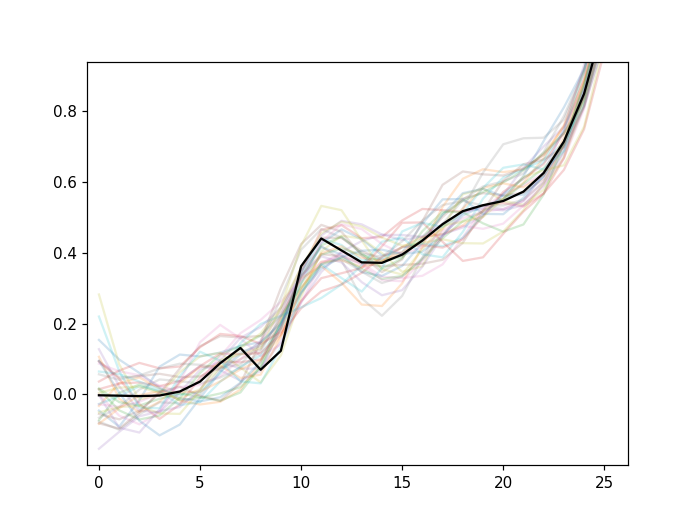

In [14]:
figure()
plot(results1['poisson']['pink'][-1]['mean_soln'],alpha=0.2)
plot(3.8*ferro_spline(np.linspace(7.110, 7.170,100)),color='k')

In [91]:
Rall = summarize_results(results, 'poisson')

In [156]:
R1 = summarize_results(results1, 'poisson', roi=slice(2,25))
R2 = summarize_results(results2, 'poisson', roi=slice(2,25))
R3 = summarize_results(results3, 'poisson', roi=slice(2,25))

In [157]:
Rall = merge_results([R2,R3])

<IPython.core.display.Javascript object>


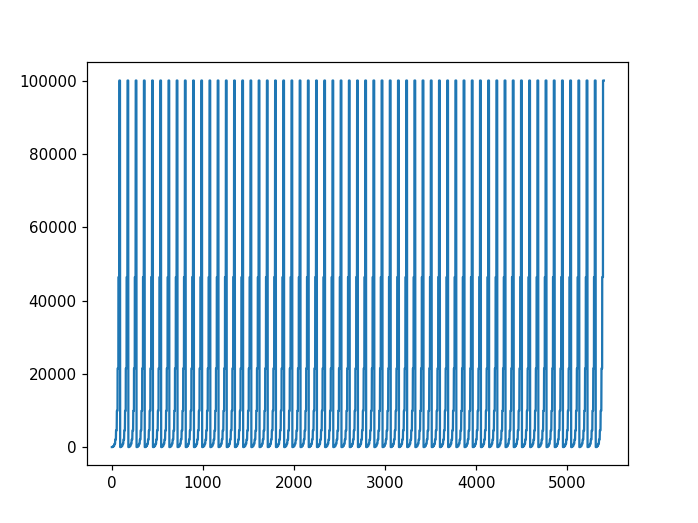

In [158]:
figure()
plot(Rall['actual_photons'])

<IPython.core.display.Javascript object>


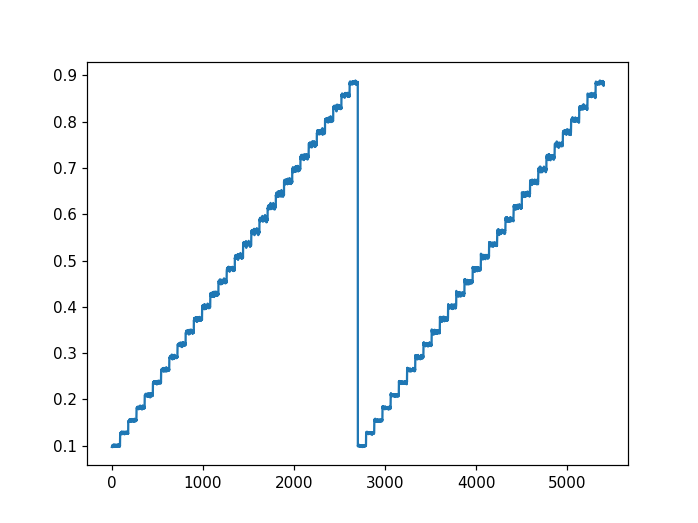

In [153]:
figure()
plot(Rall['actual_snrs'])

In [159]:
N = 11
M = 11

snr_axis = np.linspace(Rall['actual_snrs'].min(), Rall['actual_snrs'].max(), N)
p_axis = np.logspace(np.log10(Rall['actual_photons'].min()), np.log10(Rall['actual_photons'].max()), M)
ratio_summary = np.zeros((M-1,N-1))
pink_summary = np.zeros((M-1,N-1))
mono_summary = np.zeros((M-1,N-1))
for p in range(M-1):
    for s in range(N-1):
        pmask = np.logical_and(Rall['actual_photons'] < p_axis[p+1], Rall['actual_photons'] > p_axis[p])
        smask = np.logical_and(Rall['actual_snrs'] < snr_axis[s+1], Rall['actual_snrs'] > snr_axis[s])
        mask = np.logical_and(pmask,smask)
        if mask.sum() > 0:
            ratio_summary[p,s] = np.median(Rall['ratio_metric'][mask])
            pink_summary[p,s] = np.median(Rall['pink_metric'][mask])
            mono_summary[p,s] = np.median(Rall['mono_metric'][mask])

<IPython.core.display.Javascript object>


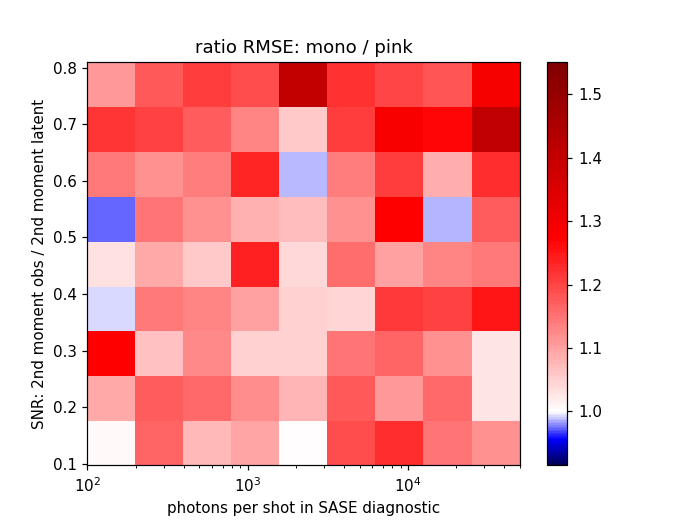

In [160]:
from matplotlib import colors
vmin = ratio_summary.min()
vmax = ratio_summary.max()
if vmin < 1.0 and vmax > 1.0:
    norm = colors.DivergingNorm(vmin=vmin, vcenter = 1.0, vmax = vmax)
    cmap = 'seismic'
else:
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = colors.LinearSegmentedColormap.from_list('cmap',
    cm.seismic(np.linspace(0.5, 1.0, 256)))
figure()
xscale('log')
pcolormesh(p_axis[:-1], snr_axis[:-1], ratio_summary.T, cmap=cmap, norm=norm)
# axvline(2.25, color='k')
# axhline(0.988, color='k')
xlabel('photons per shot in SASE diagnostic')
ylabel('SNR: 2nd moment obs / 2nd moment latent')
title('ratio RMSE: mono / pink')
colorbar()

<IPython.core.display.Javascript object>


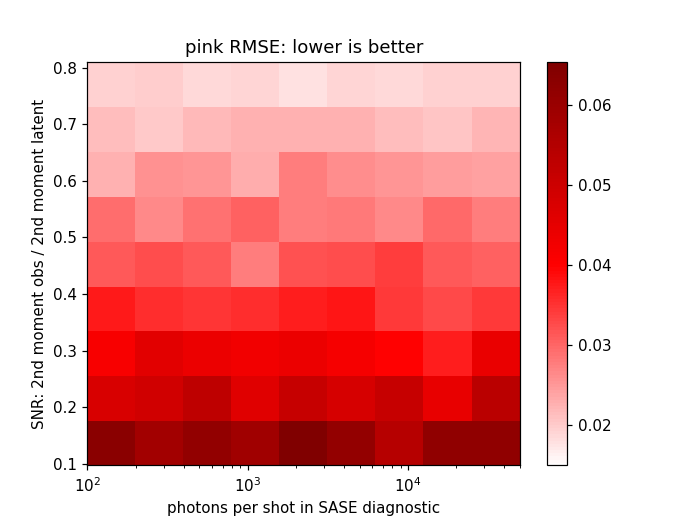

In [163]:
from matplotlib import colors
vmin = pink_summary.min()
vmax = pink_summary.max()
if vmin < 1.0 and vmax > 1.0:
    norm = colors.DivergingNorm(vmin=vmin, vcenter = 1.0, vmax = vmax)
    cmap = 'seismic'
else:
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = colors.LinearSegmentedColormap.from_list('cmap',
    cm.seismic(np.linspace(0.5, 1.0, 256)))
figure()
xscale('log')
pcolormesh(p_axis[:-1], snr_axis[:-1], pink_summary.T, cmap=cmap, norm=norm)
# axvline(2.25, color='k')
# axhline(0.988, color='k')
xlabel('photons per shot in SASE diagnostic')
ylabel('SNR: 2nd moment obs / 2nd moment latent')
title('pink RMSE: lower is better')
colorbar()

In [106]:
def plot_phase_space(kind, fnames, roi = slice(0,25), save=False, name_mod = None):
    axes = []
    ratios = []
    for fname in fnames:
        R = summarize_all_results(np.load(fname, allow_pickle=True)[()], roi=roi)
        axes.append(np.copy(R[kind]['axes']))
        ratios.append(np.copy(R[kind]['ratios']))
    coh = np.concatenate(axes,0)[::300,0] # 300 because 100 pixels x 3 noise types
    rs = np.concatenate(ratios,0)
    axs = np.concatenate(axes,0)
    N = 25
    M = 20
    snr_axis = np.linspace(axs[:,1].min(), axs[:,1].max(), N)
    coh_axis = np.linspace(axs[:,0].min(), axs[:,0].max(), M)
    ratio_summary = np.zeros((M-1,N-1))
    for c in range(M-1):
        for s in range(N-1):
            cmask = np.logical_and(axs[:,0] < coh_axis[c+1], axs[:,0] > coh_axis[c])
            smask = np.logical_and(axs[:,1] < snr_axis[s+1], axs[:,1] > snr_axis[s])
            mask = np.logical_and(cmask,smask)
            if mask.sum() > 0:
                ratio_summary[c,s] = np.median(rs[mask])
    vmin = ratio_summary.min()
    vmax = ratio_summary.max()
    if vmin < 1.0:
        norm = colors.DivergingNorm(vmin=vmin, vcenter = 1.0, vmax = vmax)
        cmap = 'seismic'
    else:
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
        cmap = colors.LinearSegmentedColormap.from_list('cmap',
        cm.seismic(np.linspace(0.5, 1.0, 256)))
    figure()
    pcolormesh(coh_axis[:-1], snr_axis[:-1], ratio_summary.T, cmap=cmap, norm=norm)
    axvline(2.25, color='k')
    # axhline(0.988, color='k')
    colorbar()
    if name_mod is not None:
        save_name = f'phase_space_{kind}_{name_mod}.pdf'
    else:
        save_name = f'phase_space_{kind}.pdf'
    if save:
        savefig(save_name)

<IPython.core.display.Javascript object>


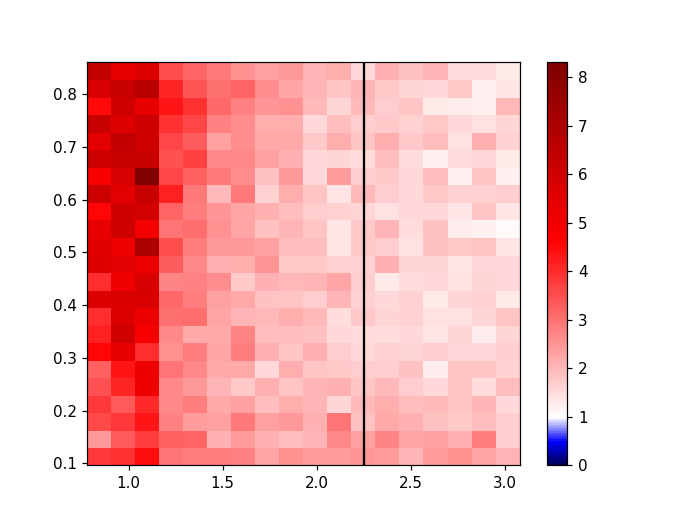

In [113]:
plot_phase_space('poisson gaussian', fnames, save=True, roi=slice(25,40), name_mod='edge')

In [ ]:
figure()
nt = 'poisson gaussian'
# plot(R[nt]['axes'][:,1], R[nt]['mono'])
# plot(R[nt]['axes'][:,1], R[nt]['pink'])
plot(R[nt]['axes'][:,1], R[nt]['ratios'],'o')

In [ ]:
R[nt]['axes']

In [ ]:
R[nt]['axes'].shape

In [ ]:
figure()
sel = -1
μ = np.squeeze(results['poisson']['mono'][sel]['mean_soln'])
gt = results['poisson']['mono'][sel]['latent_spectrum']
σ = np.squeeze(np.sqrt(results['poisson']['mono'][sel]['var_soln']))
plot(np.linspace(7.110, 7.170, 100), results['poisson']['mono'][sel]['mean_soln'])
fill_between(np.linspace(7.110, 7.170, 100), μ + 2*σ, μ - 2*σ, color='k', alpha=0.5)
plot(np.linspace(7.110, 7.170, 100), gt)
print(relative_norm(μ[:25] - gt[:25], gt[:25]))

In [ ]:
figure()
sel = 2
μ = np.squeeze(results['poisson']['pink'][sel]['mean_soln'])
σ = np.squeeze(np.sqrt(results['poisson']['pink'][sel]['var_soln']))
gt = results['poisson']['pink'][sel]['latent_spectrum']
plot(np.linspace(7.110, 7.170, 100), μ)
fill_between(np.linspace(7.110, 7.170, 100), μ + 2*σ, μ - 2*σ, color='k', alpha=0.5)
plot(np.linspace(7.110, 7.170, 100), gt)
print(relative_norm(μ[:25] - gt[:25], gt[:25]))

In [ ]:
tfp.distributions.MultivariateNormalDiag(loc=μ, scale_diag=σ).log_prob(Results['poisson']['pink'][sel]['latent_spectrum'][None,:])

In [ ]:
d.log_prob?